# 02.00-maj-logistic-regression.ipynb
Mitchell Joseph
<br>Created: 2022-11-22</br>
Last Modified: 2022-11-22

Using the dataset `../data/01-external/test_scores.csv` created in notebook 01.01-maj. We explore a simple logistic regression model using just SAT scores to predict whether a student was admitted to their first choice school.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
df = pd.read_csv("../data/01-raw/test_scores.csv")

In [3]:
df.head()

,SUBJID,SATMath,SATWriting,SATVerbal,State,Yoursex:,Race/EthnicityGroup,CHOICE,ACCPT1ST
0,884230,450,420,430,AL,Female,Black,4.0,1.0
1,884232,430,430,470,AL,Male,Black,1.0,1.0
2,884233,430,320,320,AL,Male,Black,4.0,0.0
3,884247,560,540,580,AL,Female,Black,1.0,1.0
4,884266,440,400,410,AL,Female,Two or more race/ethnicity,3.0,1.0


In [5]:
df_sub = df.sample(frac=0.2)
X = df_sub[['SATMath', 'SATWriting', 'SATVerbal']].copy().to_numpy()
Y = df_sub['ACCPT1ST'].copy().astype(np.int8).to_numpy()

In [6]:
df_sub['ACCPT1ST'].value_counts()

1.0    13722
0.0     5981
Name: ACCPT1ST, dtype: int64

## Model

We have that $y \in {0,1}$ and $x_i \in \mathbb{R}^{k+1}$

\begin{align*}
y_i &\sim \rm Bernoulli(p_i) \\
g(p_i) &= \eta_i = \sum_{i=1}^k x_{ij} \beta_j \\
\beta_j &\sim \rm Normal(0,10)
\end{align*}

In [14]:
# Normalize the data
X_std = np.zeros(X.shape)
for i in range(X.shape[1]):
    X_std[:, i] = (X[:,i] - X[:,i].mean()) / X[:, i].std()

# Make sure all columns are standardized properly
for i in range(X_std.shape[1]):
    assert np.round(X_std[:,i].mean(), 2) == 0.00
    assert np.round(X_std[:,i].std(), 2) == 1.00

X_std = np.concatenate((np.ones((X_std.shape[0],1)), X_std), axis=1)

In [16]:
model_code = """
data {
  int<lower=0> n;                // number of units
  int<lower=0> k;                // number of covariates
  matrix[n, k] X;            // covariates for each entry, including the intercept covariate
  array[n] int <lower=0,upper=1> Y;     // binary responses

  int do_prior_predictive;
}
parameters {
  vector[k] beta;            // the coefficients
}
transformed parameters {
  vector[n] eta;                // linear predictors
  eta = X * beta;
}
model {
  beta ~ normal(0, 10);

  if (do_prior_predictive != 1) {
    Y ~ bernoulli_logit(eta);
  }
}
generated quantities {
  array[n] int <lower=0,upper=1> Y_tilde;
  Y_tilde = bernoulli_logit_rng(eta);  
}
"""

## Prior predictive

In [17]:
n, k = X_std.shape
model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_std, 'Y':Y, 'do_prior_predictive':1})

Building...

In file included from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/boost/multi_array/multi_array_ref.hpp:32,
                 from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/boost/multi_array.hpp:34,
                 from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint/algebra/multi_array_algebra.hpp:22,
                 from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/boost/numeric/odeint.hpp:63,
                 from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/ode_rk45.hpp:9,
                 from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6,
                 from /home/mitch/miniconda3/envs/bayes/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:14,
                 fro


Building: 14.1s, done.

In [18]:
fit = model.sample()

Sampling:   0%
Sampling:  20% (1600/8000)
Sampling:  45% (3600/8000)
Sampling:  70% (5600/8000)
Sampling:  95% (7600/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 0.000192 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.92 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000132 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000135 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000133 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.33 seconds.
  Adjust your expectations accordingly!


In [19]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,beta.3,...,Y_tilde.19694,Y_tilde.19695,Y_tilde.19696,Y_tilde.19697,Y_tilde.19698,Y_tilde.19699,Y_tilde.19700,Y_tilde.19701,Y_tilde.19702,Y_tilde.19703
draws,,,,,,,,,,,,,,,,,,,,,
0,-3.539310,0.904211,0.774877,3.0,7.0,0.0,5.042869,4.035209,10.508159,23.278471,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,-0.979371,1.000000,0.836634,2.0,3.0,0.0,2.112235,9.043863,4.399324,-9.722293,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-1.725996,0.912249,0.881619,2.0,3.0,0.0,4.448915,2.623734,18.377657,0.632601,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-1.548845,0.854534,0.844757,3.0,7.0,0.0,4.122505,6.116926,7.155345,12.340245,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
4,-2.323872,0.946818,0.774877,3.0,7.0,0.0,6.248131,-4.686264,11.169088,-14.834159,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1.058395,0.949871,0.844757,2.0,3.0,0.0,2.253086,4.814475,9.256707,4.637166,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3996,-2.787808,0.853341,0.774877,3.0,7.0,0.0,5.833970,12.829654,-16.449398,3.055178,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3997,-2.038105,0.666853,0.836634,2.0,3.0,0.0,6.422205,19.418015,-0.362325,5.197093,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [20]:
az_fit = az.from_pystan(fit)

In [21]:
np.sum(np.array(az_fit.sample_stats['diverging']))

0

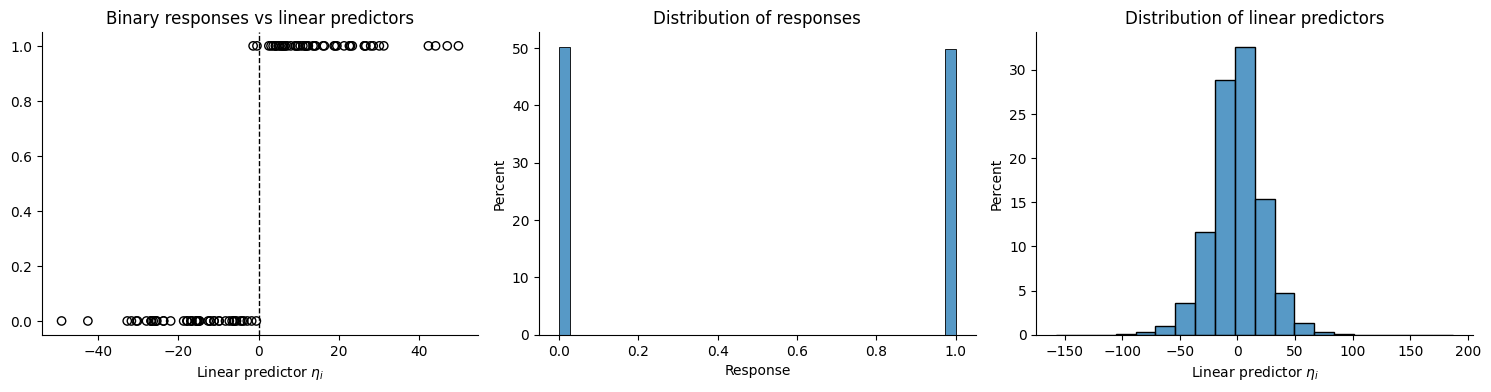

In [22]:
# Visualize prior predictive
plt.figure(figsize=(15, 4))
n_rows, n_cols = fit['eta'].shape

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  sample_col = np.random.randint(0, n_cols)
  sample_rows = np.random.choice(n_rows, size=10, replace=False)
  x = fit['eta'][sample_rows, sample_col]
  y = fit['Y_tilde'][sample_rows, sample_col]
  plt.scatter(x, y, c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

plt.subplot(132)
row_idx = np.random.choice(n_rows, size=100, replace=False)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'][row_idx, :].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'][row_idx, :].flatten(), bins=20, stat='percent')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

The first fit of our model, which used a prior on $\beta \sim \rm Normal(0,3)$, the same that was used in [JGY notebook](https://colab.research.google.com/drive/1lGwIWypWmiKC6tKvzDV-rmTyulhsaTCo?usp=sharing#scrollTo=-JpNKTtlFgks) assumed a balanced response.
However, this might not be what we'd actually expect for our dataset.
We propose that most people will get into their top choice school and so we should update our prior on $\beta$ to reflect the skewed nature of the data.
To do this we'll shift our prior belief on $\beta \sim \rm Normal(1,2)$

# Posterior fit

In [23]:
model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_std, 'Y':Y, 'do_prior_predictive':0})

Building...



Building: found in cache, done.

In [24]:
fit = model.sample()

Sampling:   0%
Sampling:   1% (100/8000)
Sampling:   2% (200/8000)
Sampling:   3% (201/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Sampling:  42% (3400/8000)
Sampling:  44% (3500/800

In [25]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,beta.3,...,Y_tilde.19694,Y_tilde.19695,Y_tilde.19696,Y_tilde.19697,Y_tilde.19698,Y_tilde.19699,Y_tilde.19700,Y_tilde.19701,Y_tilde.19702,Y_tilde.19703
draws,,,,,,,,,,,,,,,,,,,,,
0,-11913.021090,0.983239,0.383240,3.0,7.0,0.0,11913.498385,0.858662,-0.209104,-0.193292,...,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,-11914.547652,0.981092,0.378600,2.0,3.0,0.0,11914.715881,0.864693,-0.261168,-0.161111,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,-11914.293564,0.848891,0.382061,4.0,15.0,0.0,11921.729090,0.858062,-0.223675,-0.106136,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-11914.619928,0.923894,0.373256,3.0,11.0,0.0,11915.690527,0.833344,-0.209069,-0.129329,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,-11912.577208,0.994723,0.383240,4.0,15.0,0.0,11913.384706,0.839887,-0.227898,-0.142845,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-11914.846733,0.996874,0.373256,4.0,15.0,0.0,11916.935598,0.862988,-0.186254,-0.155126,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3996,-11913.545414,0.940329,0.383240,3.0,7.0,0.0,11915.034574,0.834913,-0.191469,-0.182829,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
3997,-11915.721753,0.970792,0.378600,3.0,7.0,0.0,11916.541913,0.869415,-0.234860,-0.148156,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [26]:
az_fit = az.from_pystan(fit)

In [27]:
az_fit = az.from_pystan(fit)
np.sum(np.array(az_fit.sample_stats['diverging']))

0

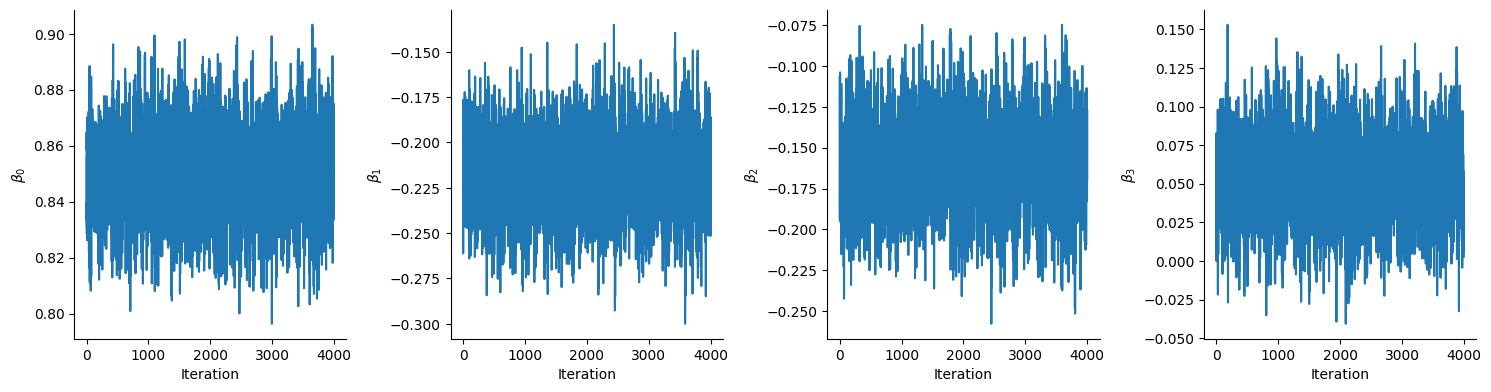

In [68]:
plt.figure(figsize=(15, 4))

for j in range(4):
  plt.subplot(1, 4, j + 1)
  plt.plot(fit['beta'][j,:])
  sns.despine()
  plt.xlabel('Iteration')
  plt.ylabel(r'$\beta_' + str(j) + '$')
  
plt.tight_layout(pad=1)

In [31]:
19703*4000

78812000

In [42]:
fit['Y_tilde'].flatten()[:10]

array([0., 1., 1., 0., 1., 1., 0., 1., 1., 1.])

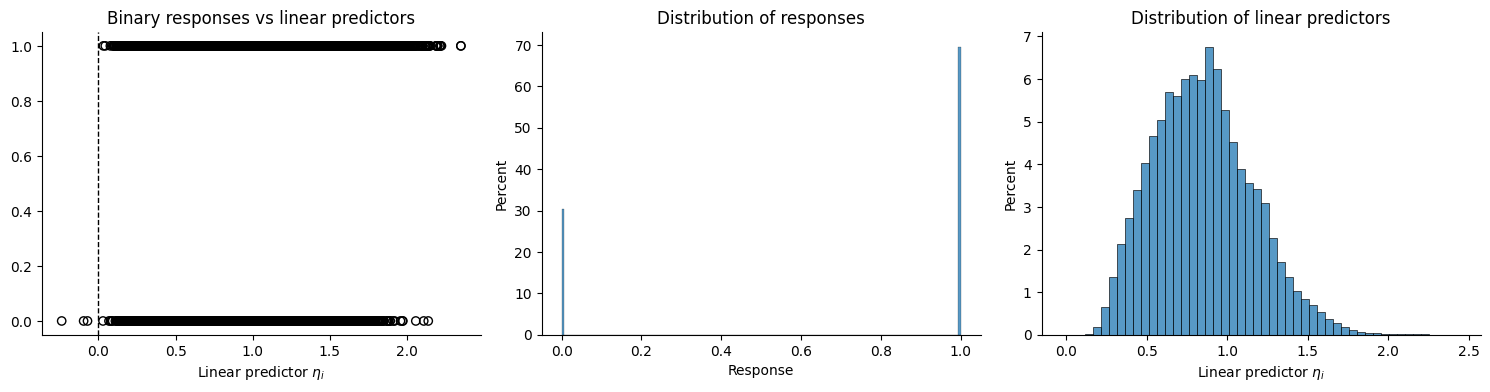

In [49]:
# Visualize prior predictive
plt.figure(figsize=(15, 4))
n_rows, n_cols = fit['eta'].shape

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(5):
  # choose a random sample
  # sample_col = np.random.randint(0, n_cols)
  # sample_rows = np.random.choice(n_rows, size=10, replace=False)

  # x = fit['eta'][sample_rows, sample_col]
  # y = fit['Y_tilde'][sample_rows, sample_col]
  t = np.random.randint(0, 4000)
  x = fit['eta'][:, t]
  y = fit['Y_tilde'][:, t]
  plt.scatter(x, y, c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

plt.subplot(132)
# row_idx = np.random.choice(n_rows, size=100, replace=False)
plt.title('Distribution of responses')
# sns.histplot(fit['Y_tilde'][row_idx, :].flatten(), stat='percent')
sns.histplot(fit['Y_tilde'].flatten()[:30_000_000], stat="percent")
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'].flatten()[:30_000_000], bins=50, stat='percent', label='Posterior Pred.')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

Most of the linear predictors are close to where the tipping point is so we shouldn't expect great performance out of this model.

In [52]:
fit['beta'].shape

(4, 4000)

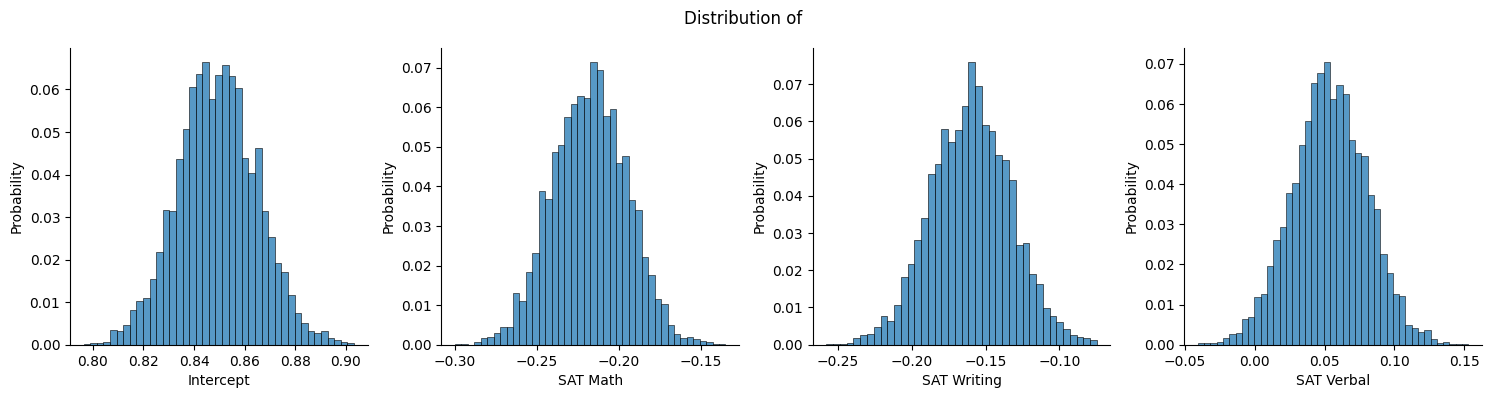

In [55]:
plot_labels = ["Intercept", "SAT Math", "SAT Writing", "SAT Verbal"]
plot_range = fit["beta"].shape[0]
plt.figure(figsize=(15, 4))

plt.suptitle("Distribution of ")
for j in range(plot_range):
  plt.subplot(1, plot_range, j + 1)
  sns.histplot(fit['beta'][j,:], stat='probability')
  sns.despine()
  plt.xlabel(plot_labels[j])

plt.tight_layout(pad=1)

In [70]:
samples1 = fit.extract(permuted=True)

AttributeError: 'Fit' object has no attribute 'extract'

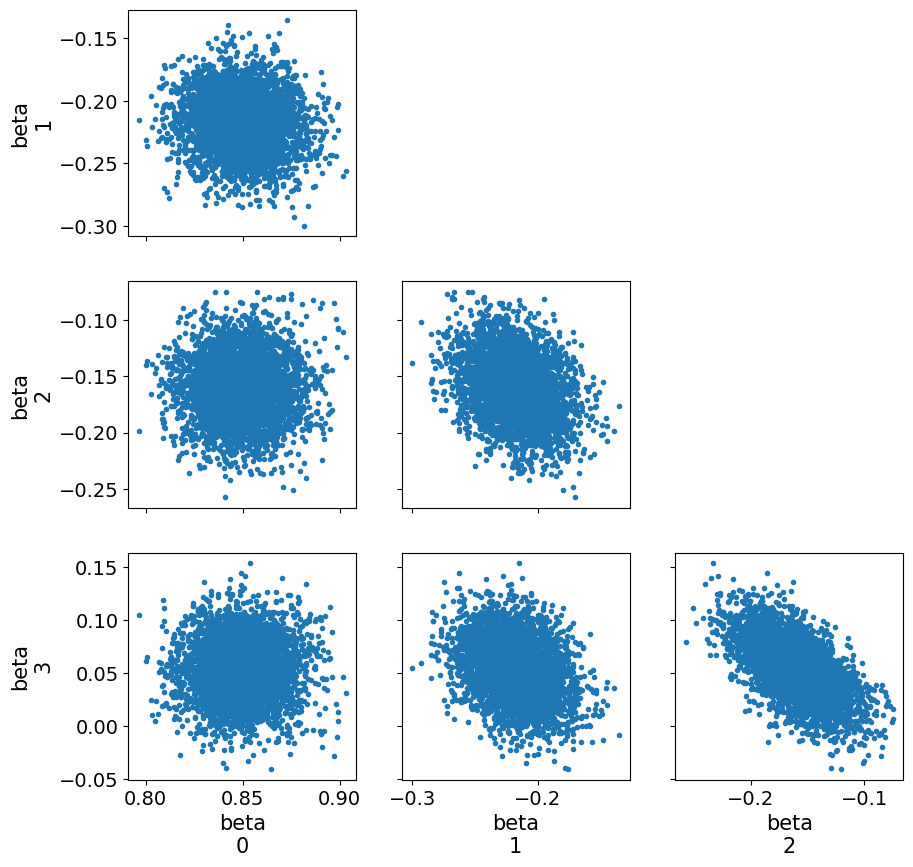

In [64]:
az.plot_pair(
    az_fit,
    var_names=['beta'],
    kind=['scatter'],
    figsize=(10,10)
)
plt.show();

Here we can see the intercept $\beta_0$ is uncorrelated with all the other betas, which makes sense.
What's nice to see is that $\beta_2$ seems to be strongly correlated with $\beta_3$, which corresponds to SAT writing and verbal respectively.
It would make sense that these two are correlated more strongly with each other than with math. 

## Full model

Now that we know the model works/runs let's try it again this time incorporating the remaining features.

In [7]:
df

,SUBJID,SATMath,SATWriting,SATVerbal,State,Yoursex:,Race/EthnicityGroup,CHOICE,ACCPT1ST
0,884230,450,420,430,AL,Female,Black,4.0,1.0
1,884232,430,430,470,AL,Male,Black,1.0,1.0
2,884233,430,320,320,AL,Male,Black,4.0,0.0
3,884247,560,540,580,AL,Female,Black,1.0,1.0
4,884266,440,400,410,AL,Female,Two or more race/ethnicity,3.0,1.0
...,...,...,...,...,...,...,...,...,...
98509,886642,610,780,740,FL,Female,Two or more race/ethnicity,1.0,1.0
98510,886644,530,610,540,FL,Female,Two or more race/ethnicity,1.0,1.0
98511,886645,660,650,690,FL,Female,White,1.0,1.0
98512,886648,580,510,550,FL,Male,White,2.0,1.0


In [8]:
dummy_mat = pd.get_dummies(df_sub[['State', 'Yoursex:', 'Race/EthnicityGroup']], prefix=None, prefix_sep='_', dummy_na=False, dtype=np.int8).to_numpy()

In [13]:
X_full = np.concatenate([X_std, dummy_mat], axis=1)
n = X_full.shape[0]
k = X_full.shape[1] - 1

## Full Model Prior Predictive

In [10]:
model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_full, 'Y':Y, 'do_prior_predictive':1})

Building...



Building: found in cache, done.

In [11]:
fit = model.sample()

Sampling:   0%
Sampling:   8% (600/8000)
Sampling:  12% (1000/8000)
Sampling:  15% (1200/8000)
Sampling:  15% (1201/8000)
Sampling:  16% (1301/8000)
Sampling:  18% (1401/8000)
Sampling:  19% (1501/8000)
Sampling:  20% (1600/8000)
Sampling:  22% (1800/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2301/8000)
Sampling:  31% (2501/8000)
Sampling:  34% (2701/8000)
Sampling:  35% (2801/8000)
Sampling:  36% (2902/8000)
Sampling:  39% (3102/8000)
Sampling:  43% (3402/8000)
Sampling:  45% (3603/8000)
Sampling:  48% (3803/8000)
Sampling:  50% (4004/8000)

In [ ]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,beta.3,...,Y_tilde.19694,Y_tilde.19695,Y_tilde.19696,Y_tilde.19697,Y_tilde.19698,Y_tilde.19699,Y_tilde.19700,Y_tilde.19701,Y_tilde.19702,Y_tilde.19703
draws,,,,,,,,,,,,,,,,,,,,,
0,-28.723582,0.904542,0.447771,3.0,7.0,0.0,50.535705,-0.008750,2.145134,1.742542,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,-29.732022,0.694964,0.540642,3.0,7.0,0.0,44.893883,0.742713,1.595703,-0.461132,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,-30.170196,0.983385,0.457293,3.0,7.0,0.0,61.028018,-0.429270,1.590653,0.565018,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,-40.850025,0.595077,0.515953,3.0,7.0,0.0,63.915092,-0.799377,1.463789,2.031132,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
4,-20.640133,0.944177,0.447771,3.0,7.0,0.0,52.435138,0.347406,1.569920,0.809699,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-18.451829,0.864854,0.515953,3.0,7.0,0.0,49.520309,0.446742,1.315566,0.738057,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
3996,-25.895277,0.802097,0.447771,3.0,7.0,0.0,49.552889,-0.746947,3.211072,2.468215,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3997,-27.691445,0.953876,0.540642,3.0,7.0,0.0,55.558528,2.020765,0.734333,0.734094,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
az_fit = az.from_pystan(fit)
np.sum(np.array(az_fit.sample_stats['diverging']))

0

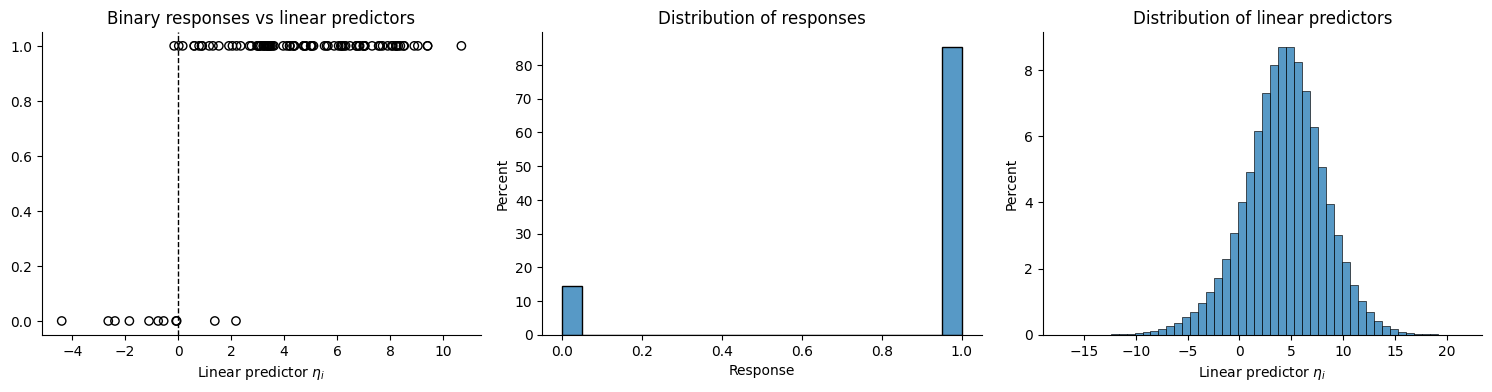

In [57]:
# Visualize prior predictive
plt.figure(figsize=(15, 4))
n_rows, n_cols = fit['eta'].shape

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  sample_col = np.random.randint(0, n_cols)
  sample_rows = np.random.choice(n_rows, size=10, replace=False)
  x = fit['eta'][sample_rows, sample_col]
  y = fit['Y_tilde'][sample_rows, sample_col]
  plt.scatter(x, y, c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

plt.subplot(132)
row_idx = np.random.choice(n_rows, size=100, replace=False)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'][row_idx, :].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'][row_idx, :].flatten(), bins=50, stat='percent', label='Posterior Pred.')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

## Full model posterior predictive

In [14]:
model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_full, 'Y':Y, 'do_prior_predictive':0})

Building...



Building: found in cache, done.

In [15]:
fit = model.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

In [18]:
az_fit = az.from_pystan(fit)
np.sum(np.array(az_fit.sample_stats['diverging']))

0

/home/mitch/.local/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


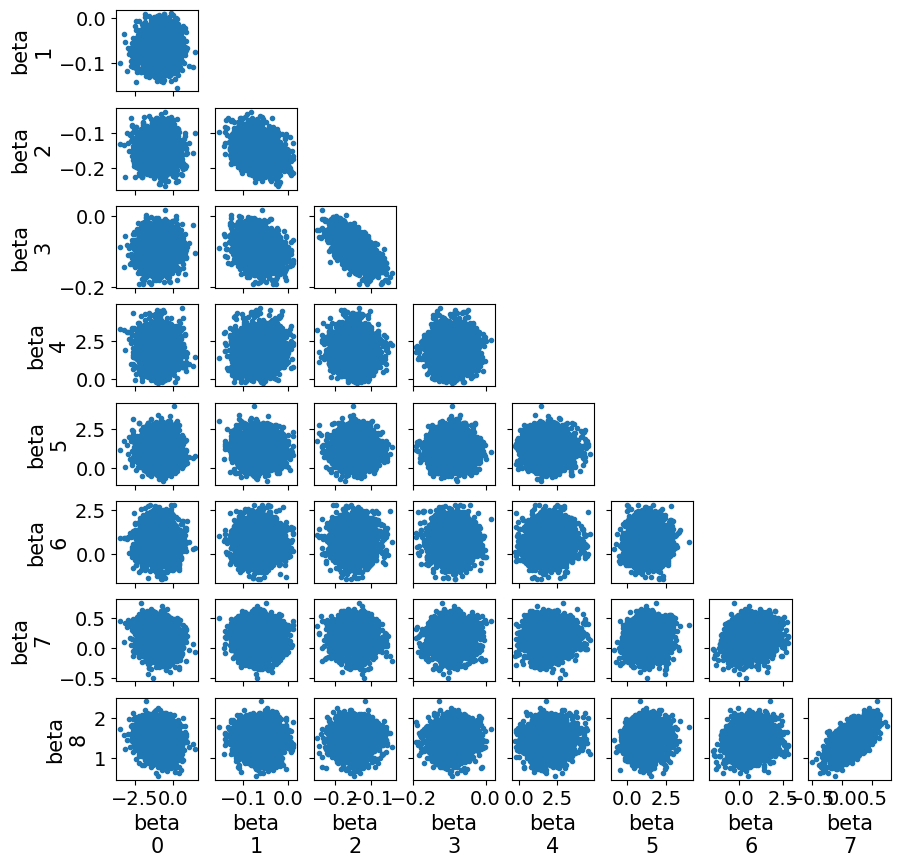

In [19]:
az.plot_pair(
    az_fit,
    var_names=['beta'],
    kind=['scatter'],
    figsize=(10,10)
)
plt.show();

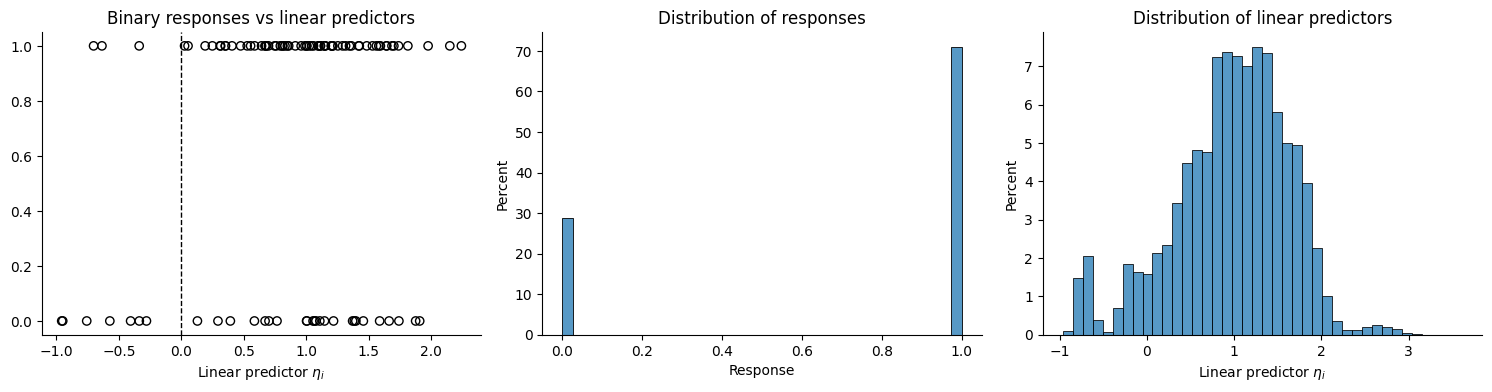

In [62]:
# Visualize posterior predictive
plt.figure(figsize=(15, 4))
n_rows, n_cols = fit['eta'].shape

plt.subplot(131)
plt.title('Binary responses vs linear predictors')
for sample_idx in range(10):
  # choose a random sample
  sample_col = np.random.randint(0, n_cols)
  sample_rows = np.random.choice(n_rows, size=10, replace=False)
  x = fit['eta'][sample_rows, sample_col]
  y = fit['Y_tilde'][sample_rows, sample_col]
  plt.scatter(x, y, c='none', edgecolors='k')
sns.despine()
plt.axvline(0, c='k', lw=1, ls='--')
plt.xlabel('Linear predictor $\eta_i$')

plt.subplot(132)
row_idx = np.random.choice(n_rows, size=100, replace=False)
plt.title('Distribution of responses')
sns.histplot(fit['Y_tilde'][row_idx, :].flatten(), stat='percent')
sns.despine()
plt.xlabel('Response')

plt.subplot(133)
sns.histplot(fit['eta'][row_idx, :].flatten(), bins=40, stat='percent', label='Posterior Pred.')
sns.despine()
plt.xlabel('Linear predictor $\eta_i$')
plt.title('Distribution of linear predictors')

plt.tight_layout(pad=1)

In [ ]:
plt.figure(figsize=(15, 4))

for j in range(4):
  plt.subplot(1, 4, j + 1)
  sns.histplot(fit['beta'][j,:], stat='probability')
  sns.despine()
  plt.xlabel(r'$\beta_' + str(j) + '$')

plt.tight_layout(pad=1)

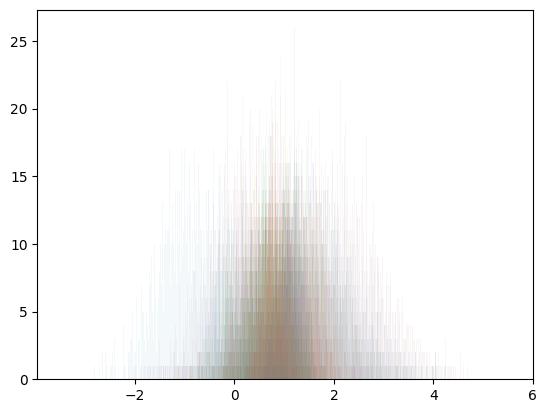

In [26]:
beta2max = dict()
for j in range(fit['beta'].shape[0]):
    y, x, _ = plt.hist(fit['beta'][j,:], alpha=0.05, bins=1000)
    beta2max[f"beta{j}"] = x[np.where(y == y.max())][0]

In [28]:
{k: v for k, v in sorted(beta2max.items(), key=lambda item: item[1])}

{'beta0': -1.0177241335646428,
 'beta47': -0.4153264825578211,
 'beta2': -0.1602858647666745,
 'beta19': -0.14139381345315805,
 'beta3': -0.09905504473976569,
 'beta1': -0.07514262458646923,
 'beta45': 0.054475047031018686,
 'beta7': 0.1297829843876412,
 'beta49': 0.1319352631418137,
 'beta46': 0.15773902357273073,
 'beta23': 0.25207334750355226,
 'beta24': 0.3008801354355659,
 'beta20': 0.5027634825158096,
 'beta15': 0.5412410996412615,
 'beta10': 0.5698470469085408,
 'beta50': 0.5923719651350741,
 'beta22': 0.6086389675716553,
 'beta6': 0.6241634687841373,
 'beta28': 0.6290479626456442,
 'beta51': 0.6483619341709528,
 'beta41': 0.6852011426230153,
 'beta43': 0.6916256542004761,
 'beta36': 0.7069421440661628,
 'beta9': 0.707253329422552,
 'beta27': 0.7439185034128655,
 'beta31': 0.748044162946299,
 'beta52': 0.7592861619942253,
 'beta53': 0.7702689294098831,
 'beta48': 0.7977138753119892,
 'beta33': 0.820794688052837,
 'beta5': 0.8609399411668943,
 'beta12': 0.8718837050462549,
 'beta

In [55]:
X_df = pd.concat([df_sub[['SATMath', "SATWriting", "SATVerbal"]], pd.get_dummies(df_sub[['State', 'Yoursex:', 'Race/EthnicityGroup']], prefix=None, prefix_sep='_', dummy_na=False, dtype=np.int8)], axis=1)
X_df.insert(loc=0, column="intercept", value=1)

print("Top 5 positive features")
print(X_df.iloc[:, [25, 4, 21, 17, 14]].columns.values, '\n')

print("Top 5 negative features ")
print(X_df.iloc[:, [47, 2, 19, 3, 1]].columns.values)

Top 5 positive features
['State_MO' 'State_0' 'State_MD' 'State_KS' 'State_ID'] 

Top 5 negative features 
['intercept' 'Yoursex:_Male' 'SATWriting' 'State_LA' 'SATVerbal' 'SATMath']


In [86]:
list(x).index("MO")

33

In [117]:
x = df['State'].value_counts().index
bottom_states = [list(x).index(i) for i in ["LA"]]
bottom_states

[26]

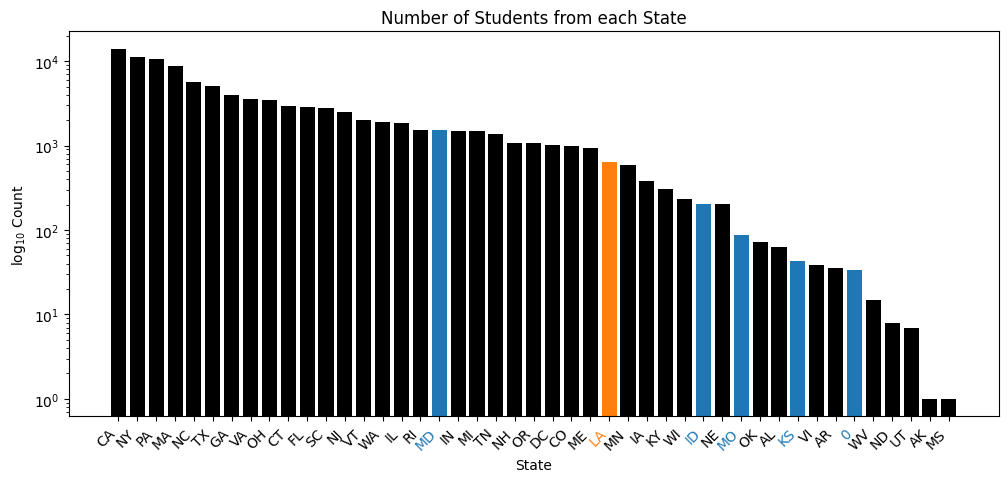

In [123]:
x = df['State'].value_counts().index
bottom_states = [list(x).index(i) for i in ["LA"]]
top_states = ["MO", "0", "MD", "KS", "ID"]
colors = ['C0' if i in top_states else 'k' for i in x]
colors[bottom_states[0]] = 'C1'
y = df['State'].value_counts().values

fig, ax = plt.subplots(1, 1, figsize=(12,5))
plt.sca(ax)
plt.bar(x, y, color=colors)
plt.xticks(rotation=45, ha='right')
top_states = [list(x).index(i) for i in ["MO", "0", "MD", "KS", "ID"]]
for i in top_states:
    ax.get_xticklabels()[i].set_color("C0")
for i in bottom_states:
    ax.get_xticklabels()[i].set_color("C1")
plt.yscale('log')
plt.title("Number of Students from each State")
plt.ylabel("$\log_{10}$ Count")
plt.xlabel("State")
plt.show();

A lot of the states that had a postive rate on acceptance came from states with an overall smaller number of applicants.
It'd be interesting to see if they also tended to apply instate.

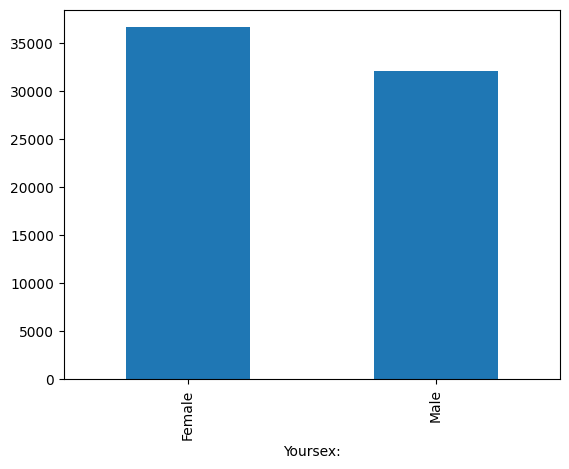

In [97]:
df.groupby('Yoursex:').agg(sum)['ACCPT1ST'].plot(kind='bar');

Doesn't seem like there's a huge difference in applications on a national scale between males and females, so it's still unclear why being male would correspond to lower acceptances. 
Possibly due to men applying to more competitive schools?

In [89]:
df['Yoursex:'].value_counts()

Female    51127
Male      47387
Name: Yoursex:, dtype: int64

It's also interesting to see that SAT scores are negatively correlated with accptance.
It should be noted that the values corresponding to SAT scores are quite small, so in the overall scheme, they seem to have a relatively small impact on acceptance.
It might be interesting to see what happens if, when we standardize, if we shift the values so they're centered around 1 or 2, just to make sure the fact they go negative isn't interfering with anything. 

In [107]:
X_std_shft = X_std.copy()
X_std_shft[:, 1:] += 3

array([[1.        , 3.75839999, 4.10284254, 4.82170292],
       [1.        , 2.8964108 , 4.19823631, 4.13611561],
       [1.        , 3.37529368, 2.67193609, 1.98141264],
       ...,
       [1.        , 0.40621982, 1.14563587, 2.17729473],
       [1.        , 3.08796395, 3.91205502, 3.64641039],
       [1.        , 3.47107026, 3.72126749, 3.84229248]])

In [109]:
X_full_shft = np.concatenate([X_std, dummy_mat], axis=1)
n = X_full_shft.shape[0]
k = X_full_shft.shape[1] - 1

model = stan.build(model_code, data={'n':n, 'k':k, 'X':X_full_shft, 'Y':Y, 'do_prior_predictive':0})
fit = model.sample()

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/

Divergences: 0


/home/mitch/.local/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


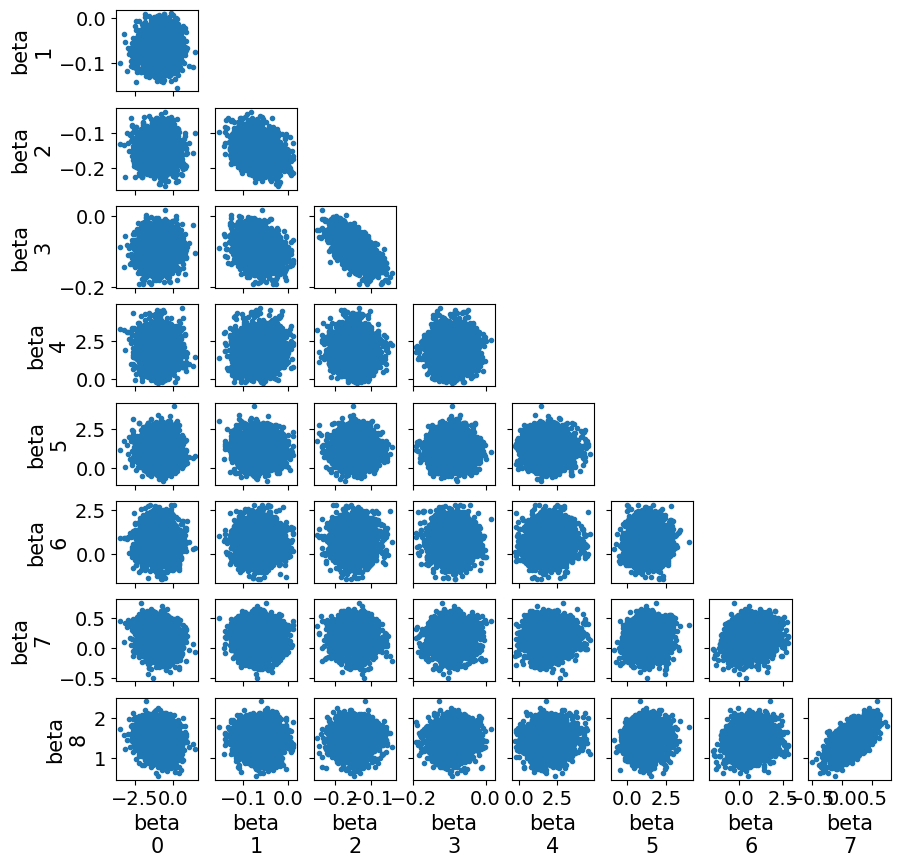

In [110]:
# Check divergences
az_fit = az.from_pystan(fit)
print(f"Divergences: {np.sum(np.array(az_fit.sample_stats['diverging']))}")

# Plot pair plot
az.plot_pair(
    az_fit,
    var_names=['beta'],
    kind=['scatter'],
    figsize=(10,10)
)
plt.show();

{'beta0': -1.0177241335646428,
 'beta47': -0.4153264825578211,
 'beta2': -0.1602858647666745,
 'beta19': -0.14139381345315805,
 'beta3': -0.09905504473976569,
 'beta1': -0.07514262458646923,
 'beta45': 0.054475047031018686,
 'beta7': 0.1297829843876412,
 'beta49': 0.1319352631418137,
 'beta46': 0.15773902357273073,
 'beta23': 0.25207334750355226,
 'beta24': 0.3008801354355659,
 'beta20': 0.5027634825158096,
 'beta15': 0.5412410996412615,
 'beta10': 0.5698470469085408,
 'beta50': 0.5923719651350741,
 'beta22': 0.6086389675716553,
 'beta6': 0.6241634687841373,
 'beta28': 0.6290479626456442,
 'beta51': 0.6483619341709528,
 'beta41': 0.6852011426230153,
 'beta43': 0.6916256542004761,
 'beta36': 0.7069421440661628,
 'beta9': 0.707253329422552,
 'beta27': 0.7439185034128655,
 'beta31': 0.748044162946299,
 'beta52': 0.7592861619942253,
 'beta53': 0.7702689294098831,
 'beta48': 0.7977138753119892,
 'beta33': 0.820794688052837,
 'beta5': 0.8609399411668943,
 'beta12': 0.8718837050462549,
 'beta

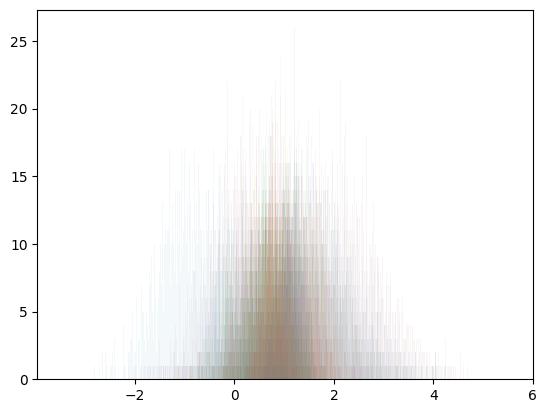

In [111]:
beta2max = dict()
for j in range(fit['beta'].shape[0]):
    y, x, _ = plt.hist(fit['beta'][j,:], alpha=0.05, bins=1000)
    beta2max[f"beta{j}"] = x[np.where(y == y.max())][0]
{k: v for k, v in sorted(beta2max.items(), key=lambda item: item[1])}

In [112]:
print("Top 5 positive features")
print(X_df.iloc[:, [25, 4, 21, 17, 14]].columns.values, '\n')

print("Top 5 negative features ")
print(X_df.iloc[:, [47, 2, 19, 3, 1]].columns.values)

Top 5 positive features
['State_MO' 'State_0' 'State_MD' 'State_KS' 'State_ID'] 

Top 5 negative features 
['Yoursex:_Male' 'SATWriting' 'State_LA' 'SATVerbal' 'SATMath']


Slightly different values for beta, but the corresponding features remain the same.

insert pairplot line 54
